Epoch 000 | Loss 0.283544
Epoch 010 | Loss 0.197184
Epoch 020 | Loss 0.273610
Epoch 030 | Loss 0.204874
Epoch 040 | Loss 0.180617
Epoch 050 | Loss 0.177068
Epoch 060 | Loss 0.170770
Epoch 070 | Loss 0.168089
Epoch 080 | Loss 0.162973
Epoch 090 | Loss 0.159840
Epoch 100 | Loss 0.160271
Epoch 110 | Loss 0.166670

Seed 42 | Accuracy: 0.9371 | F1: 0.9424 | ROC-AUC: 0.9828


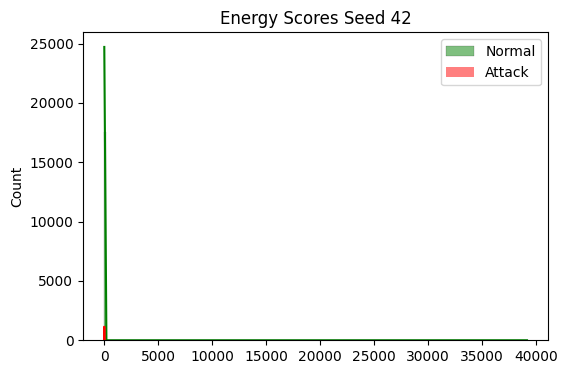


Seed 42 | CF explanations for first 3 anomalies
Anomaly index 0:
• CF Explanation: {'logged_in': 0.38271983801955134, 'serror_rate': -0.11975865365597871, 'srv_serror_rate': -0.17574489603831212, 'srv_diff_host_rate': -0.10641677595630966, 'dst_host_count': -2.8835148333692313, 'dst_host_srv_count': 0.20669418215650914, 'dst_host_same_src_port_rate': -0.18093773517267542, 'dst_host_srv_diff_host_rate': 0.20055246898030965, 'level': 1.9163132859950565}
• CF Metrics: {'proximity': np.float64(3.5117545785329294), 'sparsity': np.int64(20)}
Anomaly index 1:
• CF Explanation: {'logged_in': 0.4117840164863482, 'serror_rate': -0.11936490537259248, 'srv_serror_rate': -0.14082396517588536, 'srv_diff_host_rate': 0.3398987753382051, 'dst_host_same_src_port_rate': -0.3429057342501579, 'level': 1.7947605206256412}
• CF Metrics: {'proximity': np.float64(1.9200545684120411), 'sparsity': np.int64(20)}
Anomaly index 2:
• CF Explanation: {'logged_in': 0.4322875374519244, 'serror_rate': -0.12573664189908

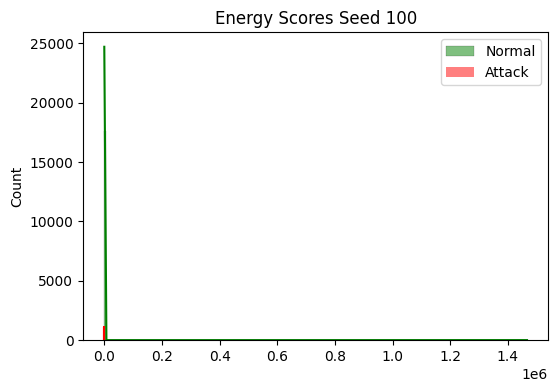


Seed 100 | CF explanations for first 3 anomalies
Anomaly index 0:
• CF Explanation: {'logged_in': 0.5393527382575884, 'count': -0.7113194932822788, 'srv_diff_host_rate': -0.42835502244488083, 'dst_host_count': -2.4600451055103303, 'dst_host_srv_count': 0.7850118243684232, 'dst_host_same_srv_rate': 0.10988599877445315, 'dst_host_diff_srv_rate': -0.12160779382764497, 'dst_host_same_src_port_rate': -0.26229122820751505, 'dst_host_srv_diff_host_rate': 0.2031008357653591, 'level': 2.249938006568482}
• CF Metrics: {'proximity': np.float64(3.5865096718394907), 'sparsity': np.int64(20)}
Anomaly index 1:
• CF Explanation: {'logged_in': 0.3285029762946978, 'count': -0.4300716771181854, 'srv_diff_host_rate': 0.23966402840522172, 'dst_host_same_src_port_rate': -0.2624754203053413, 'level': 1.8236215664630435}
• CF Metrics: {'proximity': np.float64(1.939868691465562), 'sparsity': np.int64(20)}
Anomaly index 2:
• CF Explanation: {'logged_in': 0.31561502158278376, 'count': -0.37929425673210604, 'srv

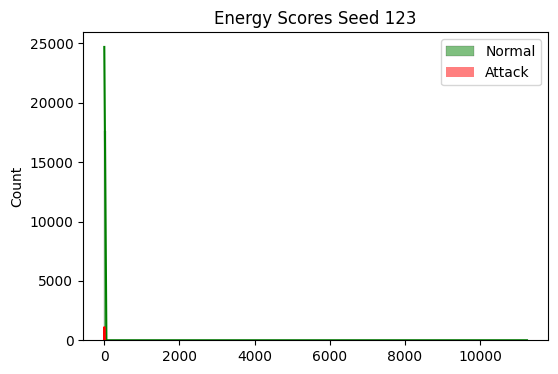


Seed 123 | CF explanations for first 3 anomalies
Anomaly index 0:
• CF Explanation: {'flag': 0.16301412992763242, 'logged_in': 0.38565095603102595, 'srv_diff_host_rate': -0.1472325018788942, 'dst_host_count': -2.749836665310836, 'dst_host_srv_count': 0.5453069770326078, 'dst_host_same_srv_rate': 0.11058671097843265, 'dst_host_srv_diff_host_rate': 0.2031008357653591, 'level': 2.2334605409389043}
• CF Metrics: {'proximity': np.float64(3.620518908052393), 'sparsity': np.int64(20)}
Anomaly index 1:
• CF Explanation: {'service': 0.10745921202883468, 'flag': 0.27445335798549375, 'logged_in': 0.22695621192091853, 'same_srv_rate': 0.14857712179323235, 'srv_diff_host_rate': 0.30641151499656083, 'dst_host_srv_count': 0.21485811114210485, 'level': 1.932428832221558}
• CF Metrics: {'proximity': np.float64(2.0109570803432284), 'sparsity': np.int64(20)}
Anomaly index 2:
• CF Explanation: {'service': 0.11878743239626632, 'flag': 0.2694938939123126, 'logged_in': 0.2512172096931353, 'same_srv_rate': 0

In [1]:
# =========================================================
# E-CLARAE-IDS + COUNTERFACTUAL EXPLAINER
# =========================================================

# ---------------------------
# 0. IMPORTS
# ---------------------------
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report
)
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(42)
np.random.seed(42)

# ---------------------------
# 1. DATA LOADING & SPLITTING
# ---------------------------
data = pd.read_csv("../data/train.csv")  # adjust path

X = data.drop("attack", axis=1).values
y = data["attack"].values  # 0 = normal, 1 = attack

X_rest, X_test, y_rest, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_normal = X_rest[y_rest == 0]
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

X_train = shuffle(X_train, random_state=42)
X_val = shuffle(X_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

feature_names = data.drop("attack", axis=1).columns.tolist()
feature_min = torch.tensor(X_train.min(axis=0), dtype=torch.float32)
feature_max = torch.tensor(X_train.max(axis=0), dtype=torch.float32)

# ---------------------------
# 2. DATASET WRAPPER
# ---------------------------
class TabularDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]

# ---------------------------
# 3. MODEL COMPONENTS
# ---------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, out_dim)
        self.bn1 = nn.BatchNorm1d(out_dim)
        self.fc2 = nn.Linear(out_dim, out_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)
        self.skip = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()
    def forward(self, x):
        identity = self.skip(x)
        out = F.leaky_relu(self.bn1(self.fc1(x)), 0.1)
        out = self.bn2(self.fc2(out))
        return F.leaky_relu(out + identity, 0.1)

class MultiHeadFeatureAttention(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.attn = nn.ModuleList([
            nn.Sequential(
                nn.Linear(dim, dim // 2),
                nn.ReLU(),
                nn.Linear(dim // 2, dim),
                nn.Sigmoid()
            ) for _ in range(heads)
        ])
    def forward(self, x):
        return torch.mean(torch.stack([a(x) * x for a in self.attn]), dim=0)

# ---------------------------
# 4. AGR-VAE MODEL
# ---------------------------
class AGRVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super().__init__()
        # Encoder
        self.enc1 = ResidualBlock(input_dim, 512)
        self.enc2 = ResidualBlock(512, 256)
        self.enc3 = ResidualBlock(256, 128)
        self.attn = MultiHeadFeatureAttention(128, heads=4)
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)
        # Decoder
        self.dec1 = ResidualBlock(latent_dim, 128)
        self.dec2 = ResidualBlock(128, 256)
        self.dec3 = ResidualBlock(256, 512)
        self.out = nn.Linear(512, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.attn(x)
        mu = self.mu(x)
        logvar = torch.clamp(self.logvar(x), min=-10, max=10)
        z = self.reparameterize(mu, logvar)
        z = self.dec1(z)
        z = self.dec2(z)
        z = self.dec3(z)
        x_hat = self.out(z)
        return x_hat, mu, logvar, z

# ---------------------------
# 5. ENERGY-AWARE LOSS
# ---------------------------
def energy_vae_loss(x, x_hat, mu, logvar, center, beta=1.0, gamma=0.1):
    center = center.to(mu.device)
    recon = torch.mean((x - x_hat) ** 2, dim=1)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1) / mu.size(1)
    latent = torch.sum((mu - center) ** 2, dim=1)
    return torch.mean(recon + beta * kl + gamma * latent)

# ---------------------------
# 6. LATENT CENTER
# ---------------------------
def compute_latent_center(model, X):
    model.eval()
    device = next(model.parameters()).device
    X = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        _, mu, _, _ = model(X)
    return mu.mean(dim=0)

# ---------------------------
# 7. TRAINING LOOP
# ---------------------------
def train(model, X_train, epochs=80, batch_size=256, beta=1.0, gamma=0.1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    loader = DataLoader(TabularDataset(X_train), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
    center = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for x in loader:
            x = x.to(device)
            x_noisy = x + 0.01 * torch.randn_like(x)
            optimizer.zero_grad()
            x_hat, mu, logvar, _ = model(x_noisy)
            if center is None:
                center = mu.mean(dim=0).detach()
            beta_w = min(beta, beta * epoch / 20)
            gamma_w = min(gamma, gamma * epoch / 20)
            loss = energy_vae_loss(x, x_hat, mu, logvar, center, beta=beta_w, gamma=gamma_w)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            total_loss += loss.item()
        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} | Loss {total_loss / len(loader):.6f}")
    return model

# ---------------------------
# 8. ENERGY SCORE
# ---------------------------
def energy_score(model, X, center, lambda_z=0.1):
    model.eval()
    device = next(model.parameters()).device
    X = torch.tensor(X, dtype=torch.float32).to(device)
    center = center.to(device)
    with torch.no_grad():
        x_hat, mu, logvar, _ = model(X)
        recon = torch.mean((X - x_hat) ** 2, dim=1)
        latent = torch.sum((mu - center) ** 2, dim=1)
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1) / mu.size(1)
    return (recon + lambda_z * latent + 0.05 * kl).cpu().numpy()

# ---------------------------
# 9. EVALUATION
# ---------------------------
def evaluate(model, X_test, y_test, threshold, center):
    scores = energy_score(model, X_test, center)
    y_pred = (scores > threshold).astype(int)
    acc = accuracy_score(y_test, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
    auc = roc_auc_score(y_test, scores)
    report = classification_report(y_test, y_pred)
    return acc, p, r, f1, auc, report, y_pred, scores

# ---------------------------
# 10. COUNTERFACTUAL EXPLAINER
# ---------------------------
class CounterfactualExplainer:
    def __init__(self, model, center, lambda_z=0.1, lambda_sparsity=0.05,
                 device=None, feature_min=None, feature_max=None):
        self.model = model
        self.center = center
        self.lambda_z = lambda_z
        self.lambda_sparsity = lambda_sparsity
        self.device = device if device else next(model.parameters()).device
        self.feature_min = feature_min
        self.feature_max = feature_max

    def decode(self, z):
        z = self.model.dec1(z)
        z = self.model.dec2(z)
        z = self.model.dec3(z)
        return self.model.out(z)

    def generate(self, x, steps=300, lr=0.05, num_samples=3):
        self.model.eval()
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            _, mu, logvar, _ = self.model(x)

        counterfactuals = []
        for _ in range(num_samples):
            z_cf = mu.clone().detach() + 0.01 * torch.randn_like(mu)
            z_cf.requires_grad_(True)
            optimizer = torch.optim.Adam([z_cf], lr=lr)

            for _ in range(steps):
                optimizer.zero_grad()
                x_hat = self.decode(z_cf)
                recon_loss = torch.mean((x - x_hat) ** 2)
                latent_loss = self.lambda_z * torch.sum((z_cf - self.center.to(self.device)) ** 2)
                sparsity_loss = self.lambda_sparsity * torch.sum(torch.abs(z_cf - mu))
                loss = recon_loss + latent_loss + sparsity_loss
                loss.backward()
                optimizer.step()

            x_cf = self.decode(z_cf).detach()
            # Plausibility
            if self.feature_min is not None and self.feature_max is not None:
                x_cf = torch.max(torch.min(x_cf, self.feature_max.to(self.device)),
                                 self.feature_min.to(self.device))
            counterfactuals.append(x_cf.cpu().numpy())
        return np.concatenate(counterfactuals, axis=0)

    def explain(self, x, x_cf, features=None, threshold=0.1):
        x = np.array(x).reshape(1, -1)
        x_cf = np.array(x_cf).reshape(1, -1)
        delta = x - x_cf
        idx = np.where(np.abs(delta[0]) > threshold)[0]
        explanation = {features[i] if features else f"feat_{i}": float(delta[0, i]) for i in idx}
        return explanation

    def metrics(self, x, x_cf):
        """Compute CF metrics: proximity, sparsity"""
        x = np.array(x).reshape(1, -1)
        x_cf = np.array(x_cf).reshape(1, -1)
        proximity = np.linalg.norm(x - x_cf, axis=1)[0]
        sparsity = np.sum(x != x_cf)
        return {"proximity": proximity, "sparsity": sparsity}

# ---------------------------
# 11. RUN FULL PIPELINE
# ---------------------------
def main():
    seeds = [42, 100, 123]
    all_metrics = []

    for seed in seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)

        model = AGRVAE(X_train.shape[1], latent_dim=64)
        model = train(model, X_train, epochs=120, beta=1.5, gamma=0.01)
        center = compute_latent_center(model, X_train)
        val_scores = energy_score(model, X_val, center)
        threshold = np.percentile(val_scores, 90)

        acc, p, r, f1, auc, report, y_pred, scores = evaluate(model, X_test, y_test, threshold, center)
        all_metrics.append([acc, p, r, f1, auc])

        print(f"\nSeed {seed} | Accuracy: {acc:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")

        # Plot energy score distribution
        plt.figure(figsize=(6,4))
        sns.histplot(scores[y_test==0], color='green', label='Normal', kde=True)
        sns.histplot(scores[y_test==1], color='red', label='Attack', kde=True)
        plt.title(f"Energy Scores Seed {seed}")
        plt.legend()
        plt.show()

        # Counterfactual explanations
        anomaly_indices = np.where(y_pred == 1)[0]
        explainer = CounterfactualExplainer(model, center, feature_min=feature_min, feature_max=feature_max)

        if len(anomaly_indices) > 0:
            print(f"\nSeed {seed} | CF explanations for first 3 anomalies")
            for idx in anomaly_indices[:3]:
                x_anomaly = X_test[idx:idx+1]
                x_cf = explainer.generate(x_anomaly, num_samples=3)
                explanation = explainer.explain(x_anomaly, x_cf[0:1], features=feature_names)
                cf_metrics = explainer.metrics(x_anomaly, x_cf[0:1])
                print(f"Anomaly index {idx}:")
                print(f"• CF Explanation: {explanation}")
                print(f"• CF Metrics: {cf_metrics}")

    all_metrics = np.array(all_metrics)
    print("\n===== FINAL METRICS ACROSS SEEDS =====")
    print(f"Accuracy: {all_metrics[:,0].mean():.4f} ± {all_metrics[:,0].std():.4f}")
    print(f"F1-score: {all_metrics[:,3].mean():.4f} ± {all_metrics[:,3].std():.4f}")
    print(f"ROC-AUC : {all_metrics[:,4].mean():.4f} ± {all_metrics[:,4].std():.4f}")

if __name__ == "__main__":
    main()
